__File: src_physics_fig.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Jun 23, 2020__

Testing some of the features of SRC physics from the standpoint of SRG operator evolution. The connection comes from looking at NN momentum distributions via the momentum occupation operator $a^{\dagger}_q a_q$ where we SRG evolve the operator and wave functions for a low-resolution description.

__Revision history:<br/>__
* Jul 10, 2020 - Reorganized by creating functions that generate the plots.
* Jul 17, 2020 - Checked that ratios of $R[<k_0|a^{\dagger}_q a_q|k_0>]$ of $^3$S$_1$  over $^1$S$_0$ with respect to $q$ reproduces ratios of $R[U(k_0,q)]$.

In [1]:
from os import chdir, getcwd
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
%matplotlib inline
from mpl_toolkits import mplot3d
import numpy as np
# Scripts made by A.T.
from Figures import figures_functions as ff
from Figures import register_colormap
import observables as ob
import operators as op
from Potentials.vsrg_macos import vnn
from SRG_codes.srg_unitary_transformation import SRG_unitary_transformation

In [2]:
# Current working directory
cwd = getcwd()

__Deuteron momentum distribution $|\psi_d(k)|^2$__

In [3]:
def deuteron_momentum_distributions(kvnns, xlim=(0.0, 10.0), ylim=(1e-8, 1e3)):
    """
    Deuteron momentum distributions [fm^3] for several potentials splitting the S- and D-states with respect
    to momentum [fm^-1].
    
    Parameters
    ----------
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [fm^3].
    
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Partial wave channel for deuteron is 3S1-3D1
    channel = '3S1'
    
    # Store momentum distibutions in dictionary
    d = {}

    # Calculate momentum distribution for each potential looping over kvnns
    for i, kvnn in enumerate(kvnns):
        
        # Set kvnn as key to dictionary
        d[kvnn] = {}

        # Load momentum and weights, Hamiltonian, and wave function
        k_array, k_weights = vnn.load_momentum(kvnn, '3S1')
        # Length of momentum array
        ntot = len(k_array)
        H_initial = vnn.load_hamiltonian(kvnn, '3S1')
        psi = ob.wave_function(H_initial)
        
        # Use this array to divide out integration factors
        factor_array = np.sqrt( 2*k_weights/np.pi ) * k_array
    
        # Calculate momentum distribution for S- and D-states
        uk_squared = ( psi[:ntot] / factor_array )**2
        wk_squared = ( psi[ntot:] / factor_array )**2
        
        # Store distributions in dictionary
        d[kvnn]['S'] = uk_squared
        d[kvnn]['D'] = wk_squared
        
        
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)
        
    # Axes labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$|\psi_d(k)|^2$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0

    # Subplot labels
    legend_size = 15
    legend_location = 'upper right'

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Loop over kvnns keeping track of indices
    for i, kvnn in enumerate(kvnns):
    
        # Curve color, styles, and labels
        curve_color = ff.xkcd_colors(i)
        curve_label = ff.kvnn_label_conversion(kvnn)
    
        # Plot S-state
        ax.semilogy(k_array, d[kvnn]['S'], color=curve_color, label=curve_label, linestyle='solid', linewidth=curve_width)
        # Plot D-state
        ax.semilogy(k_array, d[kvnn]['D'], color=curve_color, linestyle='dashed', linewidth=curve_width)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels, legend, and anchored text labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [4]:
# # Check nodes of deuteron momentum distributions for S- and D-states with AV18, RKE N4LO 450 MeV, and 
# # Gezerlis N2LO 1 fm

# kvnns = (6, 111, 222)
# f, ax = deuteron_momentum_distributions(kvnns)

# # Save figure
# file_name = 'deuteron_dist_kvnns'
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# chdir('Figures/SRC_physics')
# f.savefig(file_name + '.pdf', bbox_inches='tight')
# chdir(cwd)

__Contributions to $<\psi_d|a^{\dagger}_q a_q|\psi_d>$__

In [5]:
def deuteron_integrand_contours(q, kvnn, generator, lamb, lambda_bd=0.00, clim=(-8, -3)):
    """
    Plots the integrand of the SRG-evolved <\psi_d|\ataq|\psi_d> [fm^5] with respect to momentum [fm^-1] for
    momentum value q [fm^-1] and the deuteron wave function \psi_d. This is a 1 x 1 log-scaled contour plot.
    
    Parameters
    ----------
    q : float
        Momentum projection value [fm^-1].
    kvnn : int
        This number specifies the potential.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].
    clim : tuple, optional
        Tuple specifying the minimum and maximum power of the log-scaled colorbar (e.g. (-8, -3) means the colorbar
        spans 10^-8 to 10^-3).

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """

    # --- Set-up --- #
    
    # Partial wave channel is 3S1-3D1 for deuteron
    channel = '3S1'
    
    # Load momentum, weights, and initial Hamiltonian
    k_array, k_weights = vnn.load_momentum(kvnn, channel)
    # Length of k_array
    ntot = len(k_array)
    H_initial = vnn.load_hamiltonian(kvnn, channel)
    # Divide out these factors to present mesh-independent result (need to double the size for coupled-channel)
    factor_array = np.concatenate( (np.sqrt(k_weights), np.sqrt(k_weights)) )
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Axes limits
    axes_max = 5.0
    axes_lim = (0.0, axes_max)
        

    # --- Calculate contributions --- #
    
    # Initialize dictionary to store contributions for table and figure
    d = {}
    
    # Load unitary transformation
    # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
    if generator == 'Block-diag':
        H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0, lambda_bd=lamb)
    else:
        H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
    U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
            
    # Initial and evolved momentum projection operators
    operator_initial = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix, smeared=False)
    operator_evolved = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix, smeared=False)
            
    # Load initial and evolved wave functions dividing out momentum and weights
    psi_initial = ob.wave_function(H_initial)
    psi_evolved = ob.wave_function(H_initial, U=U_matrix)
    
    # Each contribution to <\psi_d|\ataq|\psi_d> comparing initial and evolved
    # Initial
    ss_cont_initial = abs( psi_initial.T[:ntot] @ operator_initial[:ntot, :ntot] @ psi_initial[:ntot] )
    sd_cont_initial = abs( psi_initial.T[:ntot] @ operator_initial[:ntot, ntot:] @ psi_initial[ntot:] )
    ds_cont_initial = abs( psi_initial.T[ntot:] @ operator_initial[ntot:, :ntot] @ psi_initial[:ntot] )
    dd_cont_initial = abs( psi_initial.T[ntot:] @ operator_initial[ntot:, ntot:] @ psi_initial[ntot:] )
    
    # Initial <\psi_d|\ataq|\psi_d>
    total_initial = ss_cont_initial + sd_cont_initial + ds_cont_initial + dd_cont_initial
    
    # Evolved
    ss_cont_evolved = abs( psi_evolved.T[:ntot] @ operator_evolved[:ntot, :ntot] @ psi_evolved[:ntot] )
    sd_cont_evolved = abs( psi_evolved.T[:ntot] @ operator_evolved[:ntot, ntot:] @ psi_evolved[ntot:] )
    ds_cont_evolved = abs( psi_evolved.T[ntot:] @ operator_evolved[ntot:, :ntot] @ psi_evolved[:ntot] )
    dd_cont_evolved = abs( psi_evolved.T[ntot:] @ operator_evolved[ntot:, ntot:] @ psi_evolved[ntot:] )
    
    # Evolved <\psi_d|\ataq|\psi_d>
    total_evolved = ss_cont_evolved + sd_cont_evolved + ds_cont_evolved + dd_cont_evolved
    
    # Print each relative contribution in dictionary
    print('--- Initial ---')
    print( 'S-S = %.4f' % (ss_cont_initial / total_initial * 100) )
    print( 'S-D = %.4f' % (sd_cont_initial / total_initial * 100) )
    print( 'D-S = %.4f' % (ds_cont_initial / total_initial * 100) )
    print( 'D-D = %.4f' % (dd_cont_initial / total_initial * 100) )
    print('--- Evolved ---')
    print( 'S-S = %.4f' % (ss_cont_evolved / total_evolved * 100) )
    print( 'S-D = %.4f' % (sd_cont_evolved / total_evolved * 100) )
    print( 'D-S = %.4f' % (ds_cont_evolved / total_evolved * 100) )
    print( 'D-D = %.4f' % (dd_cont_evolved / total_evolved * 100) )
    
    # Mesh-grids of psi
    psi_row, psi_col = np.meshgrid(psi_evolved / factor_array, psi_evolved / factor_array)
        
    # Matrix elements of < psi | a^dagger_q a_q | psi > (without factors of dk dk')
    integrand = psi_row * (operator_evolved / row / col) * psi_col
    # Re-size
    integrand_ss = abs(integrand[:ntot, :ntot])
    integrand_sd = abs(integrand[:ntot, ntot:])
    integrand_ds = abs(integrand[ntot:, :ntot])
    integrand_dd = abs(integrand[ntot:, ntot:])
            
    # Interpolate the integrand through 0 to axes_max for smoother looking figure (the extension _int means 
    # interpolated)
    k_array_int, integrand_ss_int = ff.interpolate_matrix(k_array, integrand_ss, axes_max + 0.2)
    k_array_int, integrand_sd_int = ff.interpolate_matrix(k_array, integrand_sd, axes_max + 0.2)
    k_array_int, integrand_ds_int = ff.interpolate_matrix(k_array, integrand_ds, axes_max + 0.2)
    k_array_int, integrand_dd_int = ff.interpolate_matrix(k_array, integrand_dd, axes_max + 0.2)

    # Store in dictionary with sub
    d['ss'] = integrand_ss_int
    d['sd'] = integrand_sd_int
    d['ds'] = integrand_ds_int
    d['dd'] = integrand_dd_int
    
    
    # --- Plot data --- #
    
    # Size of figure
    row_number = 2
    col_number = 2
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar
        
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = ff.convert_ticks_to_labels(axes_ticks)
    axes_tick_size = 18
        
    # Colorbar ticks, label, and fontsize
    mn = clim[0]
    mx = clim[1]
    levels_number = 61
    levels = np.logspace(mn, mx, levels_number)
    levels_ticks = np.logspace(mn, mx, mx-mn+1)
    levels_ticks_strings = [r'$10^{%d}$' % step for step in range(mn, mx+1)]
    colorbar_label = '[fm' + r'$^5$' + ']'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    
    # Color scheme for contour plots
    color_style = 'Blues'
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over sub-blocks keeping track of indices
    for i, char_i in enumerate(['s', 'd']):
        for j, char_j in enumerate(['s', 'd']):
            
            # This creates the sub-block string (e.g. 'sd')
            cc = char_i + char_j
            
            c = axs[i, j].contourf(k_array_int, k_array_int, d[cc], levels, norm=colors.LogNorm(),
                                   cmap=color_style, extend='both')
                                         
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks_strings)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks_strings)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

--- Initial ---
S-S = 22.4779
S-D = 24.7238
D-S = 24.7238
D-D = 28.0744
--- Evolved ---
S-S = 85.1541
S-D = 7.1222
D-S = 7.1222
D-D = 0.6016


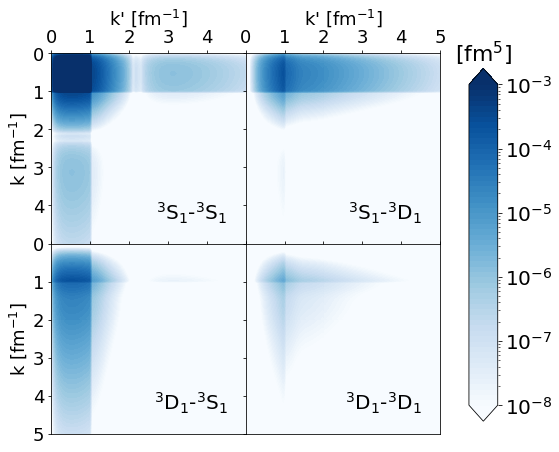

In [6]:
# Contours of momentum projection operator integrand with deuteron wave function using band-diagonal 
# transformations from AV18 where q = 2 fm^-1

q = 2.0
kvnn = 6
generator = 'Block-diag'
lamb = 1.0
lambda_bd = 1.35

f, axs = deuteron_integrand_contours(q, kvnn, generator, lamb, lambda_bd)

label_size = 20
label_location = 'lower right'
for i, char_i in enumerate(['S', 'D']):
    for j, char_j in enumerate(['S', 'D']):
        label = r'$^3{\rm %s}_1$' % char_i + '-' + r'$^3{\rm %s}_1$' % char_j
        anchored_text = AnchoredText(label, frameon=False, loc=label_location, prop=dict(size=label_size))
        axs[i, j].add_artist(anchored_text)

# Save figure
file_name = 'deuteron_integrand_contours_q%.1f_kvnn_%d_%s' % (q, kvnn, generator)
file_name = ff.replace_periods(file_name) + '.png'
chdir('Figures/SRC_physics')
f.savefig(file_name, bbox_inches='tight')
chdir(cwd)

--- Initial ---
S-S = 62.0277
S-D = 11.5379
D-S = 11.5379
D-D = 14.8964
--- Evolved ---
S-S = 90.7252
S-D = 4.4007
D-S = 4.4007
D-D = 0.4735


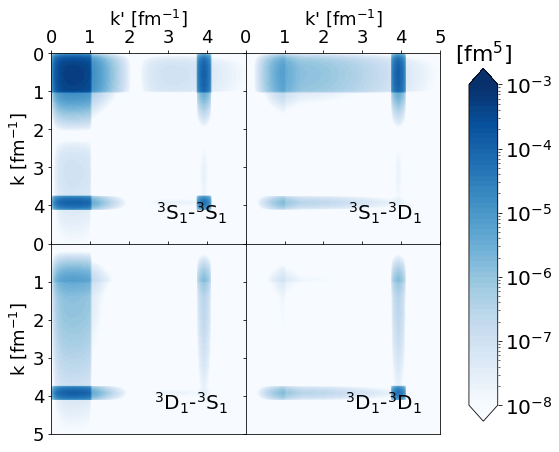

In [7]:
# Contours of momentum projection operator integrand with deuteron wave function using band-diagonal 
# transformations from AV18 where q = 4 fm^-1

q = 4.0
kvnn = 6
generator = 'Block-diag'
lamb = 1.0
lambda_bd = 1.35

f, axs = deuteron_integrand_contours(q, kvnn, generator, lamb, lambda_bd)

label_size = 20
label_location = 'lower right'
for i, char_i in enumerate(['S', 'D']):
    for j, char_j in enumerate(['S', 'D']):
        label = r'$^3{\rm %s}_1$' % char_i + '-' + r'$^3{\rm %s}_1$' % char_j
        anchored_text = AnchoredText(label, frameon=False, loc=label_location, prop=dict(size=label_size))
        axs[i, j].add_artist(anchored_text)

# Save figure
file_name = 'deuteron_integrand_contours_q%.1f_kvnn_%d_%s' % (q, kvnn, generator)
file_name = ff.replace_periods(file_name) + '.png'
chdir('Figures/SRC_physics')
f.savefig(file_name, bbox_inches='tight')
chdir(cwd)

--- Initial ---
S-S = 23.9683
S-D = 24.4050
D-S = 24.4050
D-D = 27.2218
--- Evolved ---
S-S = 87.2780
S-D = 6.1385
D-S = 6.1385
D-D = 0.4450


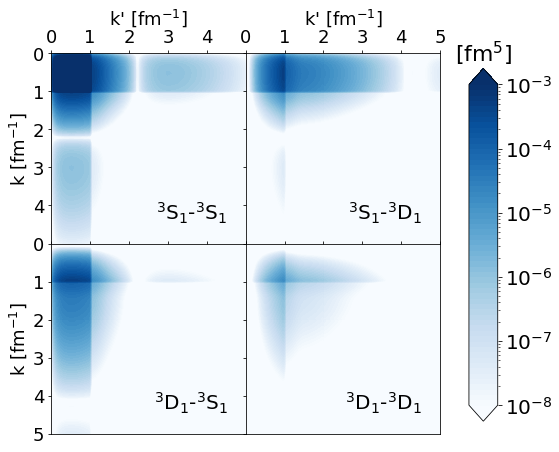

In [8]:
# Contours of momentum projection operator integrand with deuteron wave function using band-diagonal 
# transformations from Gezerlis N2LO 1 fm where q = 2 fm^-1

q = 2.0
kvnn = 222
generator = 'Block-diag'
lamb = 1.0
lambda_bd = 1.35

f, axs = deuteron_integrand_contours(q, kvnn, generator, lamb, lambda_bd)

label_size = 20
label_location = 'lower right'
for i, char_i in enumerate(['S', 'D']):
    for j, char_j in enumerate(['S', 'D']):
        label = r'$^3{\rm %s}_1$' % char_i + '-' + r'$^3{\rm %s}_1$' % char_j
        anchored_text = AnchoredText(label, frameon=False, loc=label_location, prop=dict(size=label_size))
        axs[i, j].add_artist(anchored_text)

# Save figure
file_name = 'deuteron_integrand_contours_q%.1f_kvnn_%d_%s' % (q, kvnn, generator)
file_name = ff.replace_periods(file_name) + '.png'
chdir('Figures/SRC_physics')
f.savefig(file_name, bbox_inches='tight')
chdir(cwd)

--- Initial ---
S-S = 69.9157
S-D = 9.2921
D-S = 9.2921
D-D = 11.5001
--- Evolved ---
S-S = 92.8200
S-D = 3.4486
D-S = 3.4486
D-D = 0.2828


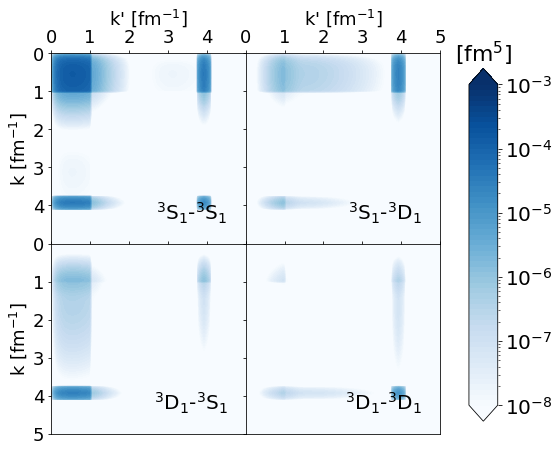

In [9]:
# Contours of momentum projection operator integrand with deuteron wave function using band-diagonal 
# transformations from Gezerlis N2LO 1 fm where q = 4 fm^-1

q = 4.0
kvnn = 222
generator = 'Block-diag'
lamb = 1.0
lambda_bd = 1.35

f, axs = deuteron_integrand_contours(q, kvnn, generator, lamb, lambda_bd)

label_size = 20
label_location = 'lower right'
for i, char_i in enumerate(['S', 'D']):
    for j, char_j in enumerate(['S', 'D']):
        label = r'$^3{\rm %s}_1$' % char_i + '-' + r'$^3{\rm %s}_1$' % char_j
        anchored_text = AnchoredText(label, frameon=False, loc=label_location, prop=dict(size=label_size))
        axs[i, j].add_artist(anchored_text)

# Save figure
file_name = 'deuteron_integrand_contours_q%.1f_kvnn_%d_%s' % (q, kvnn, generator)
file_name = ff.replace_periods(file_name) + '.png'
chdir('Figures/SRC_physics')
f.savefig(file_name, bbox_inches='tight')
chdir(cwd)

__Ratio of SRG transformations: $U_{3S1}$ / $U_{1S0}$__

In [10]:
def srg_transformation_ratios_fixed_q(q_points, kvnn, generator, lamb, lambda_bd=0.00, xlim=(0.0, 2.5), 
                                      ylim=(1e-1, 2e3)):
    """
    Plots ratios of U(k, q_i)_{3S1} / U(k, q_i)_{1S0} with respect to momentum k [fm^-1] where k < \lambda or
    \Lambda_BD < q_points. This is a 1 x 1 semilog plot.
    
    Parameters
    ----------
    q_points : 1-D ndarray
        q values in the ratio U(k, q_i)_{3S1} / U(k, q_i)_{1S0} [fm^-1].
    kvnn : int
        This number specifies the potential.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis (which is log scale and unitless).
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """

    # --- Set up --- #
    
    # Load momentum and weights (channel argument doesn't matter here)
    k_array, k_weights = vnn.load_momentum(kvnn, '1S0')
    
    # Length of the momentum array
    ntot = len(k_array)
    
    # Divide out integration factors with factor_array
    factor_array = np.sqrt( (2*k_weights) / np.pi ) * k_array
    row, col = np.meshgrid(factor_array, factor_array)
    # Same thing but for coupled-channel
    factor_array_cc = np.concatenate( (factor_array, factor_array) )
    row_cc, col_cc = np.meshgrid(factor_array_cc, factor_array_cc)
    
    # Load initial and evolved Hamiltonians [MeV], and SRG transformations
    # 1S0
    H_initial_1s0 = vnn.load_hamiltonian(kvnn, '1S0')
    H_evolved_1s0 = vnn.load_hamiltonian(kvnn, '1S0', method='srg', generator=generator, lamb=lamb,
                                         lambda_bd=lambda_bd)
    # 3S1
    H_initial_3s1 = vnn.load_hamiltonian(kvnn, '3S1')
    H_evolved_3s1 = vnn.load_hamiltonian(kvnn, '3S1', method='srg', generator=generator, lamb=lamb,
                                         lambda_bd=lambda_bd)
    
    # Calculate SRG transformation with eigenvectors of initial and evolved Hamiltonians dividing out 
    # integration factors
    U_matrix_1s0 = SRG_unitary_transformation(H_initial_1s0, H_evolved_1s0) / row / col
    U_matrix_3s1 = SRG_unitary_transformation(H_initial_3s1, H_evolved_3s1) / row_cc / col_cc
    
    
    # --- Calculate ratios --- #
    
    # Store results in dictionary where q_i values are the keys
    d = {}

    # Loop over q_i values
    for q_i in q_points:
    
        d[q_i] = {}
    
        # Index of q in k_array
        q_i_index = op.find_q_index(q_i, k_array)
        
        # Calculate |U(k, q_i)_{3S1}|^2
        numerator_array = U_matrix_3s1[:ntot, q_i_index] * U_matrix_3s1.T[q_i_index, :ntot] + \
                          U_matrix_3s1[:ntot, ntot+q_i_index] * U_matrix_3s1.T[ntot+q_i_index, :ntot]
        
        # Calculate |U(k, q_i)_{1S0}|^2
        denominator_array = U_matrix_1s0[:ntot, q_i_index] * U_matrix_1s0.T[q_i_index, :ntot]
        
        # Store ratio in dictionary
        d[q_i] = numerator_array / denominator_array
        
        
    # --- Plot ratios --- #

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$|U_{3S1}(k,q_i)|^2/|U_{1S0}(k,q_i)|^2$'
    y_label_size = 20
    axes_tick_size = 14
    
    # Legend label
    legend_size = 15
    legend_location = 'upper left'

    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Loop over q_points keeping track of index
    for i, q_i in enumerate(q_points):
        
        # Curve color and label
        curve_color = ff.xkcd_colors(i)
        curve_label = r'$q_%d=%d$' % (i+1, q_i) + ' fm' + r'$^{-1}$'
        
        # Add curve to figure
        ax.semilogy(k_array, d[q_i], color=curve_color, label=curve_label, linestyle='solid', linewidth=curve_width)

    # Add horizontal line at 1
    ax.axhline(y=1, color='xkcd:black', linestyle='dotted')
        
    # Shade gray from \lambda or \Lambda_BD value to maximum momentum on plot
    if generator == 'Block-diag':
        ax.fill_betweenx(ylim, lambda_bd, k_array[-1], edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)
    else:
        ax.fill_betweenx(ylim, lamb, k_array[-1], edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels and legend
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)

    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [11]:
# # Plots ratios of  U(k, q_i)_{3S1} / U(k, q_i)_{1S0} for AV18 and Wegner generator

# q_points = np.array( (2.0, 4.0, 6.0, 8.0, 9.0 ) )
# kvnn = 6
# generator = 'Wegner'
# lamb = 1.0
# f, ax = srg_transformation_ratios_fixed_q(q_points, kvnn, generator, lamb)

# # Add potential and generator label
# kvnn_label = 'AV18'
# generator_label = ff.generator_label_conversion(generator)
# full_label = kvnn_label + '\n' + generator_label
# label_size = 17
# label_location = 'upper right'
# anchored_text = AnchoredText(full_label, loc=label_location, prop=dict(size=label_size))
# ax.add_artist(anchored_text)

# # Save figure
# file_name = 'srg_transformation_ratios_kvnn_%d_%s_q_points' % (kvnn, generator)
# for q_i in q_points:
#     file_name += '_%d' % q_i
# chdir('Figures/SRC_physics')
# f.savefig(file_name + '.pdf', bbox_inches='tight')
# chdir(cwd)

In [12]:
# # Plots ratios of  U(k, q_i)_{3S1} / U(k, q_i)_{1S0} for AV18 and block-diagonal generator

# q_points = np.array( (2.0, 4.0, 6.0, 8.0, 9.0 ) )
# kvnn = 6
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 1.5
# f, ax = srg_transformation_ratios_fixed_q(q_points, kvnn, generator, lamb, lambda_bd)

# # Add potential and generator label
# kvnn_label = 'AV18'
# generator_label = ff.generator_label_conversion(generator)
# full_label = kvnn_label + '\n' + generator_label
# label_size = 17
# label_location = 'upper right'
# anchored_text = AnchoredText(full_label, loc=label_location, prop=dict(size=label_size))
# ax.add_artist(anchored_text)

# # Save figure
# file_name = 'srg_transformation_ratios_kvnn_%d_%s_q_points' % (kvnn, generator)
# for q_i in q_points:
#     file_name += '_%d' % q_i
# chdir('Figures/SRC_physics')
# f.savefig(file_name + '.pdf', bbox_inches='tight')
# chdir(cwd)

In [13]:
# # Plots ratios of  U(k, q_i)_{3S1} / U(k, q_i)_{1S0} for N2LO and Wegner generator

# q_points = np.array( (2.0, 4.0, 6.0, 8.0, 9.0 ) )
# kvnn = 222
# generator = 'Wegner'
# lamb = 1.0
# ylim = (1e-1, 1e4)
# f, ax = srg_transformation_ratios_fixed_q(q_points, kvnn, generator, lamb, ylim=ylim)

# # Add potential and generator label
# kvnn_label = 'N' + r'$^2$' + 'LO'
# generator_label = ff.generator_label_conversion(generator)
# full_label = kvnn_label + '\n' + generator_label
# label_size = 17
# label_location = 'upper right'
# anchored_text = AnchoredText(full_label, loc=label_location, prop=dict(size=label_size))
# ax.add_artist(anchored_text)

# # Save figure
# file_name = 'srg_transformation_ratios_kvnn_%d_%s_q_points' % (kvnn, generator)
# for q_i in q_points:
#     file_name += '_%d' % q_i
# chdir('Figures/SRC_physics')
# f.savefig(file_name + '.pdf', bbox_inches='tight')
# chdir(cwd)

In [14]:
def srg_transformation_ratios_fixed_k(k_0, kvnns, generator, lamb, lambda_bd=0.00, xlim=(0.0, 4.0), ylim=(1e0, 1e3)):
    """
    Plots ratios of U(k_0, q)_{3S1} / U(k_0, q)_{1S0} with respect to momentum k [fm^-1] where k_0 < \lambda or
    \Lambda_BD < q. This is a 1 x 1 semilog plot.
    
    Parameters
    ----------
    k_0 : float
        k_0 value in the ratio U(k_0, q)_{3S1} / U(k_0, q)_{1S0} [fm^-1].
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (6, 222)).
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis (which is log scale and unitless).
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """

    # --- Set up --- #
    
    # Store results in dictionary where kvnns are the keys
    d = {}
    
    for kvnn in kvnns:
    
        # Load momentum and weights (channel argument doesn't matter here)
        k_array, k_weights = vnn.load_momentum(kvnn, '1S0')
    
        # Length of the momentum array
        ntot = len(k_array)
    
        # Divide out integration factors with factor_array
        factor_array = np.sqrt( (2*k_weights) / np.pi ) * k_array
        row, col = np.meshgrid(factor_array, factor_array)
        # Same thing but for coupled-channel
        factor_array_cc = np.concatenate( (factor_array, factor_array) )
        row_cc, col_cc = np.meshgrid(factor_array_cc, factor_array_cc)
    
        # Load initial and evolved Hamiltonians [MeV], and SRG transformations
        # 1S0
        H_initial_1s0 = vnn.load_hamiltonian(kvnn, '1S0')
        H_evolved_1s0 = vnn.load_hamiltonian(kvnn, '1S0', method='srg', generator=generator, lamb=lamb,
                                             lambda_bd=lambda_bd)
        # 3S1
        H_initial_3s1 = vnn.load_hamiltonian(kvnn, '3S1')
        H_evolved_3s1 = vnn.load_hamiltonian(kvnn, '3S1', method='srg', generator=generator, lamb=lamb,
                                             lambda_bd=lambda_bd)
    
        # Calculate SRG transformation with eigenvectors of initial and evolved Hamiltonians dividing out 
        # integration factors
        U_matrix_1s0 = SRG_unitary_transformation(H_initial_1s0, H_evolved_1s0) / row / col
        U_matrix_3s1 = SRG_unitary_transformation(H_initial_3s1, H_evolved_3s1) / row_cc / col_cc
    
        # Index of k_0 in k_array
        k_0_index = op.find_q_index(k_0, k_array)
        
        # Calculate |U(k_0, q)_{3S1}|^2 = \sum_{l=0,2} 
        numerator_array = U_matrix_3s1[k_0_index, :ntot] * U_matrix_3s1.T[:ntot, k_0_index] + \
                          U_matrix_3s1[k_0_index, ntot:] * U_matrix_3s1.T[ntot:, k_0_index]
        
        # Calculate |U(k, q_i)_{1S0}|^2
        denominator_array = U_matrix_1s0[k_0_index, :ntot] * U_matrix_1s0.T[:ntot, k_0_index]
        
        # Store ratio in dictionary
        d[kvnn] = numerator_array / denominator_array
        
        
    # --- Plot ratios --- #

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$|U_{3S1}(k_0,q)|^2/|U_{1S0}(k_0,q)|^2$'
    y_label_size = 20
    axes_tick_size = 14
    
    # Legend label
    legend_size = 15
    legend_location = 'upper left'

    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Loop over kvnns keeping track of index
    for i, kvnn in enumerate(kvnns):
        
        # Curve color and label
        curve_color = ff.xkcd_colors(i)
        curve_label = ff.kvnn_label_conversion(kvnn)
        
        # Add curve to figure
        ax.semilogy(k_array, d[kvnn], color=curve_color, label=curve_label, linestyle='solid',
                    linewidth=curve_width)
        
    # Shade gray from 0 to \lambda or \Lambda_BD value on plot
    if generator == 'Block-diag':
        ax.fill_betweenx(ylim, 0.0, lambda_bd, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)
    else:
        ax.fill_betweenx(ylim, 0.0, lamb, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels and legend
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)

    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [15]:
# # Plots ratios of  U(k_0, q)_{3S1} / U(k_0, q)_{1S0} for AV18, EMN N4LO 500 MeV, 
# # RKE N4LO 450 MeV, and Gezerlis N2LO 1 fm with Wegner generator

# k_0 = 0.1
# kvnns = (6, 79, 111, 222)
# generator = 'Wegner'
# lamb = 1.35
# xlim = (0.0, 4.0)
# ylim = (1e0, 1e3)
# f, ax = srg_transformation_ratios_fixed_k(k_0, kvnns, generator, lamb, xlim=xlim, ylim=ylim)

# # Add generator and \lambda label as anchored text
# generator_label = ff.generator_label_conversion(generator)
# generator_size = 18
# generator_location = 'upper left'
# anchored_text = AnchoredText(generator_label, loc=generator_location, prop=dict(size=generator_size))
# ax.add_artist(anchored_text)

# # Save figure
# file_name = 'srg_transformation_ratios_k0_%.1f_%s_lamb_%.2f_kvnns' % (k_0, generator, lamb)
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name = ff.replace_periods(file_name)
# chdir('Figures/SRC_physics')
# f.savefig(file_name + '.pdf', bbox_inches='tight')
# chdir(cwd)

In [16]:
# # Plots ratios of  U(k_0, q)_{3S1} / U(k_0, q)_{1S0} for AV18, EMN N4LO 500 MeV, 
# # RKE N4LO 450 MeV, and Gezerlis N2LO 1 fm with block-diagonal generator

# k_0 = 0.1
# kvnns = (6, 79, 111, 222)
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 1.35
# xlim = (0.0, 4.0)
# ylim = (1e0, 1e3)
# f, ax = srg_transformation_ratios_fixed_k(k_0, kvnns, generator, lamb, lambda_bd, xlim=xlim, ylim=ylim)

# # Add generator and \lambda label as anchored text
# generator_label = ff.generator_label_conversion(generator)
# generator_size = 18
# generator_location = 'lower left'
# anchored_text = AnchoredText(generator_label, loc=generator_location, prop=dict(size=generator_size))
# ax.add_artist(anchored_text)

# # Save figure
# file_name = 'srg_transformation_ratios_k0_%.1f_%s_Lamb_%.2f_lamb_%.1f_kvnns' % (k_0, generator, lambda_bd, lamb)
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name = ff.replace_periods(file_name)
# chdir('Figures/SRC_physics')
# f.savefig(file_name + '.pdf', bbox_inches='tight')
# chdir(cwd)

__Visualization of $U(k,k')$__

In [17]:
def srg_transformation_contours(kvnns, channels, generator, lamb, lambda_bd=2.0, clim=(-0.1, 0.1)):
    """
    Plots SRG unitary transformations [fm^3] with respect to momentum [fm^-1]. This is an m x n contour plot where
    m is the size of channels and n is the size of kvnns.
    
    Parameters
    ----------
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    channels : tuple
        The partial wave channels (e.g. ('1S0', '3S1')).
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].
    clim : tuple, optional
        Tuple specifying the minimum and maximum power of the log-scaled colorbar (e.g. (-8, -3) means the colorbar
        spans 10^-8 to 10^-3).

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Size of figure
    row_number = len(channels)
    col_number = len(kvnns)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar
    
    # Axes limits
    axes_max = 5.0
    axes_lim = (0.0, axes_max)
    
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = ff.convert_ticks_to_labels(axes_ticks)
    axes_tick_size = 18
    
    # Colorbar ticks, label, and fontsize
    mn = clim[0]
    mx = clim[1]
    levels_number = 61
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 9)
    levels_ticks_strings = ff.convert_ticks_to_labels(levels_ticks)
    colorbar_label = '[fm' +r'$^3$' + ']'
    colorbar_label_size = 20
    colorbar_tick_size = 18

    # Color scheme for contour plots
    color_style = 'turbo'

    
    # --- Load transformations --- #
    
    # Initialize dictionary to store transformations and momentum arrays
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
        
        # Store momentum and transformation in here
        d[kvnn] = {}
        
        # Loop over channels
        for channel in channels:
            
            # Store momentum array and transformation in here
            d[kvnn][channel] = {}
        
            # Load momentum and weights, initial Hamiltonian, and build factor_array for dividing out
            # momentum and weights
            k_array, k_weights = vnn.load_momentum(kvnn, channel)
            H_initial = vnn.load_hamiltonian(kvnn, channel)
            ntot = len(k_array)
            factor_array = k_array * np.sqrt( 2*k_weights / np.pi )
            row, col = np.meshgrid(factor_array, factor_array)
            
            # Load unitary transformation
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            if generator == 'Block-diag':
                H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0,
                                                 lambda_bd=lambda_bd)
            else:
                H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
            
            U_matrix = SRG_unitary_transformation(H_initial, H_evolved)[:ntot, :ntot]
        
            # Subtract out identity matrix and divide out momentum and weights
            I = np.eye(ntot, ntot)
            delta_U = (U_matrix - I) / row / col
        
            # Interpolate and store in dictionary
            k_array_int, delta_U_int = ff.interpolate_matrix(k_array, delta_U, axes_max+0.2)
        
            # Store in dictionary with kvnn, 'k_array', and generator as keys 
            d[kvnn][channel]['k'] = k_array_int
            d[kvnn][channel]['U'] = delta_U_int
    
    
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over channels keeping track of indices
    for i, channel in enumerate(channels):
        # Loop over kvnns keeping track of indices
        for j, kvnn in enumerate(kvnns):
            
            c = axs[i, j].contourf(d[kvnn][channel]['k'], d[kvnn][channel]['k'], d[kvnn][channel]['U'], levels,
                                   cmap=color_style, extend='both')
        
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks_strings)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks_strings)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axes
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set tick size and labels
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [18]:
# # Contours of AV18, RKE N4LO 450 MeV, Gezerlis N2LO 1 fm SRG transformations

# kvnns = (6, 111, 222)
# channels = ('3S1', '1S0')
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 1.35
# clim = (-0.2, 0.2)
# f, axs = srg_transformation_contours(kvnns, channels, generator, lamb, lambda_bd, clim=clim)

# # Add kvnn label to each subplot on the bottom row
# kvnn_label_size = 17
# kvnn_label_location = 'lower right'
# for j, kvnn in enumerate(kvnns):
#     kvnn_label = ff.kvnn_label_conversion(kvnn)
#     anchored_text = AnchoredText(kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size))
#     axs[len(channels)-1, j].add_artist(anchored_text)

# # Add channel labels to 1st sub-plots on the 1st column
# channel_label_size = 20
# channel_label_location = 'upper right'
# for i, channel in enumerate(channels):
#     channel_label = ff.channel_label_conversion(channel)
#     anchored_text = AnchoredText(channel_label, loc=channel_label_location,
#                                  prop=dict(size=channel_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Set file name
# file_name = 'srg_transformation_contours_kvnns'
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_%s_Lamb_%.2f_lamb_%.1f' % (generator, lambda_bd, lamb)
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure as .png
# chdir('Figures/SRC_physics')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [19]:
def srg_transformation_3d_plot(kvnn, channel, generator, lamb, lambda_bd=2.0, zlim=(-0.2, 0.2)):
    """
    Plots a SRG unitary transformation [fm^3] with respect to momentum [fm^-1]. This is an 1 x 1 3-D plot.
    
    Parameters
    ----------
    kvnn : int
        Number which specifies the potential (e.g. 111).
    channel : str
        The partial wave channels (e.g. '1S0').
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].
    zlim : tuple, optional
        Tuple specifying the minimum and maximum value of the z-axis [fm^3].

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Axes limits
    axes_max = 5.0
    axes_lim = [0.0, axes_max]
    
    # Load momentum and weights
    k_array, k_weights = vnn.load_momentum(kvnn, channel)
    ntot = len(k_array)
    
    # Create factor array to divide out integration factors
    factor_array = np.sqrt( 2*k_weights/np.pi ) * k_array
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Load Hamiltonians and calculate U(k,k')
    H_initial = vnn.load_hamiltonian(kvnn, channel)
    H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb, lambda_bd=lambda_bd)
    U_matrix_full = SRG_unitary_transformation(H_initial, H_evolved)
    
    # Pair down to ntot size
    U_matrix = U_matrix_full[:ntot, :ntot]
    
    # Subtract out identity matrix and divide out momentum and weights
    I = np.eye(ntot, ntot)
    delta_U = (U_matrix - I) / row / col
        
    # Interpolate and store in dictionary
    k_array_int, delta_U_int = ff.interpolate_matrix(k_array, delta_U, axes_max + 0.2)
    k_rows, k_cols = np.meshgrid(k_array_int, k_array_int)
#     k_rows, k_cols = np.meshgrid(k_array, k_array)

    
    # --- Plot data --- #
    
    # Size of figure
    row_number = 1
    col_number = 2 # Set wider for better viewing angle (even though it's 1 x 1)
    figure_size = (4*col_number, 3.5*row_number)

    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    z_ticks = np.linspace(zlim[0], zlim[1], 5)
    z_tick_labels = [''] + ff.convert_ticks_to_labels(z_ticks[1:])
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = ff.convert_ticks_to_labels(axes_ticks)
    axes_tick_size = 15
    
    # Number of contour levels
    levels_number = 601
    
    # Color scheme for contour plots
    color_style = 'turbo'
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    ax = plt.axes(projection='3d')
    ax.plot_surface(k_rows, k_cols, delta_U_int, vmin=zlim[0], vmax=zlim[1], cmap=color_style)
#     ax.plot_surface(k_rows, k_cols, delta_U, vmin=zlim[0], vmax=zlim[1], cmap=color_style)
        
    # Specify axes limits
    ax.set_xlim( axes_lim )
    ax.set_ylim( axes_lim )
    ax.set_zlim( zlim )
                     
    # Specify axes tick marks
    ax.xaxis.set_ticks(axes_ticks)
    ax.xaxis.set_ticklabels(axes_ticks_strings)
    ax.yaxis.set_ticks(axes_ticks)
    ax.yaxis.set_ticklabels(axes_ticks_strings)
    ax.zaxis.set_ticks(z_ticks)
    ax.zaxis.set_ticklabels(z_tick_labels)
    ax.tick_params(labelsize=axes_tick_size)

    # Set axes label
    ax.set_xlabel('\n'+x_label, fontsize=axes_label_size, labelpad=15)
    ax.set_ylabel('\n'+y_label, fontsize=axes_label_size, labelpad=15)

    # Invert y-axis
    plt.gca().invert_yaxis()
    
    plt.tight_layout()

    return f, ax

In [20]:
# # 3-D plot of SRG transformation for AV18 in 3S1 channel with Wegner generator

# kvnn = 6
# channel = '3S1'
# generator = 'Wegner'
# lamb = 1.35
# zlim = (-0.5, 0.5)
# f, ax = srg_transformation_3d_plot(kvnn, channel, generator, lamb, zlim=zlim)

# # Adjust viewing angle
# ax.view_init(50, 120) # Rotate \theta and \phi 
# ax.dist = 12 # Manually zoom in/out to prevent axes labels from being cutoff

# # Set file name
# file_name = 'srg_transformation_3d_plot_kvnn_%d_%s_%s.png' % (kvnn, channel, generator)

# # Save figure as .pdf
# chdir('Figures/SRC_physics')
# bbox = Bbox([[1.0, 0.0], [7.5, 3.5]])
# f.savefig(file_name, bbox_inches=bbox) # Cut out unnecessary white space
# chdir(cwd)

__Extras__

In [21]:
# SANITY CHECK: should be the same as srg_transformation_ratios_fixed_k!
def ataq_ratios_fixed_k(k_0, kvnns, generator, lamb, lambda_bd=0.00, xlim=(0.0, 4.0), ylim=(1e0, 1e3)):
    """
    Temporary test function.
    """

    # --- Set up --- #
    
    # Store results in dictionary where kvnns are the keys
    d = {}
    
    for kvnn in kvnns:
    
        # Load momentum and weights (channel argument doesn't matter here)
        k_array, k_weights = vnn.load_momentum(kvnn, '1S0')
    
        # Length of the momentum array
        ntot = len(k_array)
    
        # Load initial and evolved Hamiltonians [MeV], and SRG transformations
        # 1S0
        H_initial_1s0 = vnn.load_hamiltonian(kvnn, '1S0')
        H_evolved_1s0 = vnn.load_hamiltonian(kvnn, '1S0', method='srg', generator=generator, lamb=lamb,
                                             lambda_bd=lambda_bd)
        # 3S1
        H_initial_3s1 = vnn.load_hamiltonian(kvnn, '3S1')
        H_evolved_3s1 = vnn.load_hamiltonian(kvnn, '3S1', method='srg', generator=generator, lamb=lamb,
                                             lambda_bd=lambda_bd)
    
        # Calculate SRG transformation with eigenvectors of initial and evolved Hamiltonians dividing out 
        # integration factors
        U_matrix_1s0 = SRG_unitary_transformation(H_initial_1s0, H_evolved_1s0)
        U_matrix_3s1 = SRG_unitary_transformation(H_initial_3s1, H_evolved_3s1)
    
        # Index of k_0 in k_array
        k_0_index = op.find_q_index(k_0, k_array)
        ratio_array = np.zeros(ntot)
        
        # Test normalization too
        psi_3s1 = ob.wave_function(H_initial_3s1, U=U_matrix_3s1)
        norm_3s1 = 0.0
        
        for i, q in enumerate(k_array):
        
            operator_3s1 = op.momentum_projection_operator(q, k_array, k_weights, '3S1', U=U_matrix_3s1, smeared=False)
            operator_1s0 = op.momentum_projection_operator(q, k_array, k_weights, '1S0', U=U_matrix_1s0, smeared=False)
            ratio_array[i] = operator_3s1[k_0_index, k_0_index] / operator_1s0[k_0_index, k_0_index]
            
            norm_3s1 += 2/np.pi*k_array[i]**2*k_weights[i] * (psi_3s1.T @ operator_3s1 @ psi_3s1)
        
        print(norm_3s1)

        # Store ratio in dictionary
        d[kvnn] = ratio_array
        
        
    # --- Plot ratios --- #

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$R[a^{\dagger}_q a_q(k_0,q)]$'
    y_label_size = 20
    axes_tick_size = 14
    
    # Legend label
    legend_size = 15
    legend_location = 'upper left'

    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Loop over kvnns keeping track of index
    for i, kvnn in enumerate(kvnns):
        
        # Curve color and label
        curve_color = ff.xkcd_colors(i)
        curve_label = ff.kvnn_label_conversion(kvnn)
        
        # Add curve to figure
        ax.semilogy(k_array, d[kvnn], color=curve_color, label=curve_label, linestyle='solid',
                    linewidth=curve_width)
        
    # Shade gray from 0 to \lambda or \Lambda_BD value on plot
    if generator == 'Block-diag':
        ax.fill_betweenx(ylim, 0.0, lambda_bd, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)
    else:
        ax.fill_betweenx(ylim, 0.0, lamb, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels and legend
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)

    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [22]:
# # Plots ratios of  U(k_0, q)_{3S1} / U(k_0, q)_{1S0} for AV18, EMN N4LO 500 MeV, 
# # RKE N4LO 450 MeV, and Gezerlis N2LO 1 fm with block-diagonal generator

# k_0 = 0.1
# kvnns = (6, 79, 111, 222)
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 1.5
# xlim = (0.0, 4.0)
# ylim = (1e0, 1e3)
# f, ax = ataq_ratios_fixed_k(k_0, kvnns, generator, lamb, lambda_bd=lambda_bd, xlim=xlim, ylim=ylim)

# # Save figure
# file_name = 'ataq_ratios_k0_%.1f_%s_Lamb_%.1f_lamb_%.1f_kvnns' % (k_0, generator, lambda_bd, lamb)
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name = ff.replace_periods(file_name)
# chdir('Figures/SRC_physics')
# f.savefig(file_name + '.pdf', bbox_inches='tight')
# chdir(cwd)